# [NTDS'18] Team project
[ntds'18]: https://github.com/mdeff/ntds_2018

## Students

* Team: `<34>`
* Students: `<Valentin Morel, Xavier Sieber, Cédric Schumacher, Charles-Théophile Coen>`
* Dataset: `<Terrorist attack>`

In [4]:
%matplotlib inline

import numpy as np
import networkx as nx
import pandas as pd
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from pyunlocbox import functions, solvers
from scipy.optimize import minimize as opt
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, SpectralClustering

In [16]:
## Loading of files

# Features: mean of 126; std of 149
features = np.load('features_matrix.npy')

# Labels
labels =  np.load('labels_vector.npy')

# Location
adjacency_location = np.load('adjacency_location.npy')
n_nodes = len(adjacency_location)
location = np.load('location_vector.npy')

# Weighted adjacency matrix of the distance from features
adjacency_weights = np.load('adjacency_weights_matrix.npy')

gt = np.load('gt.npy')
x = np.load('projection_matrix.npy')

In [9]:
## Definition of fonctions

def distance_weighted(i,j):
    return adjacency_weights[i,j]

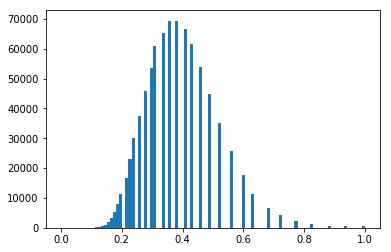

In [5]:
# Visualization of the distrubution of the distances of features
weights_hist = np.zeros(int(n_nodes*(n_nodes-1)/2))
n = 0
for i in range(0,n_nodes):
    for j in range(i+1,n_nodes):
        weights_hist[n] = adjacency_weights[i,j]
        n += 1
plt.hist(weights_hist, bins = np.linspace(0,1,100))   
plt.show()

##### **Remarks**
The adjacency_weights matrix allow us to picture the difference between two features. The smaller the value between two node's features the more similar they are in terms of their features.

In [6]:
unique_ele, unique_indices, unique_counts = np.unique(location, return_index = True, return_counts = True)
mapping = {}
for i in range(0,len(unique_ele)):
    if unique_counts[i] > 1:
        mapping[unique_ele[i]] = {'numbers':unique_counts[i], 'indices':np.where(location == unique_ele[i])[0]}
        

# List of keys of the dictionnary
keys = list(mapping.keys())
# List of values of dict containing numbers and indices of nodes with the same location
values = list(mapping.values()) 
# List of all the indexes of locations with more than one attack
index_attack = []
for i in range(0,len(keys)):
    index_attack.append(list(mapping[keys[i]]['indices']))
    
index_attack = [val for sublist in index_attack for val in sublist]   

In [7]:
weights_dict = {}
for i in keys:
    num_nodes_same_loc = mapping[i]['numbers']
    distances = np.zeros(int((num_nodes_same_loc)*(num_nodes_same_loc-1)/2))
    index = 0
    for j in range(0,num_nodes_same_loc):
        for k in range(j+1,num_nodes_same_loc):
            distances[index] = distance_weighted(mapping[i]['indices'][j],mapping[i]['indices'][k])
            index += 1

    weights_dict[i] = {'distances':distances, 'mean': np.mean(distances), 'std': np.std(distances)}

In [8]:
labels_dict = {}
for i in keys:
    num_nodes_same_loc = mapping[i]['numbers']
    lab = []
    for j in range(0,num_nodes_same_loc):
        lab.append(labels[mapping[i]['indices'][j]][0])

    labels_dict[i] = lab

recap_label = {}
for i in keys:
    unique_ele, unique_counts = np.unique(labels_dict[i], return_counts = True)
    total_attacks = mapping[i]['numbers']
    list_attacks = [];
    for j in range(0,len(unique_ele)):
        list_attacks.append({unique_ele[j]: np.round(unique_counts[j]/total_attacks*100)})

    list_attacks.append(total_attacks)
    recap_label[i] =  list_attacks

In [9]:
def plot_recap_label(k):
    
    numb = np.size(recap_label[k])-1
    x = []
    y = []
    for i in range(0,numb):
        x.append(list(recap_label[k][i].keys()))
        y.append(list(recap_label[k][i].values()))
        
    x = [val for sublist in x for val in sublist]
    y = [val for sublist in y for val in sublist] 
    
    plt.bar(x,y)
    plt.title('Distribution of attacks for location %i. Number of attacks at this location: %i.' %(k ,recap_label[k][-1]))
    plt.show()
    return

##### **Remarks**
The *mapping* dictionary contains the locations where multiple attacks were perpetrated. For each location, the number of attacks(n) is specified and the indices of the nodes are stored in an array.

The *weights_dict* dictionary contains the weighted distance in terms of features between every attacks perpetrated at the same location. The distances are stored in an array of *(n-1)n/2* values where n is the number of attacks at this location. The goal of this dictionary is to find any links between the colocated attacks and their features.

The *labels_dict* dictionary contains the type of attacks for the attacks perpetrated at the same location. *recap_label* dictionary is a summary of *labels_dict* with only the percentage for each type of attack. The goal of these dictionaries is to find any links between the colocated attacks and the type of attack.

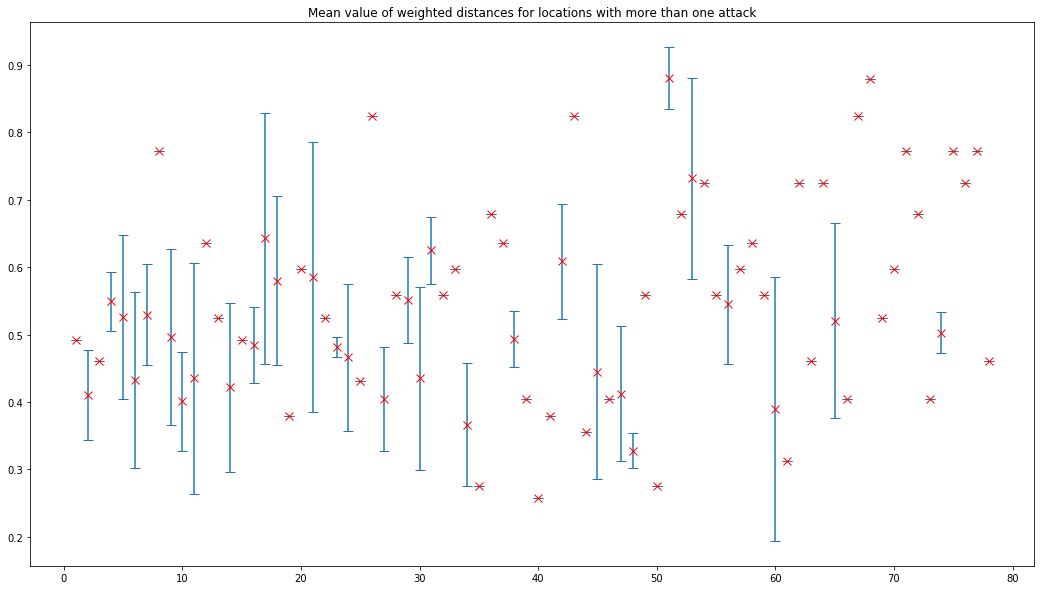

In [10]:
x = list(weights_dict.keys())
y = np.zeros(len(x))
yerr = np.zeros(len(x))
index = 0
for i in x:
    y[index] = weights_dict[i]['mean']
    yerr[index] = weights_dict[i]['std']
    index += 1

plt.figure(figsize=(18,10))
plt.errorbar(np.linspace(1,len(x),len(x)),y,yerr, linestyle='None',marker='x', markersize= 8,
                    markeredgecolor = [1,0,0],capsize=5)
plt.title('Mean value of weighted distances for locations with more than one attack')
plt.show()

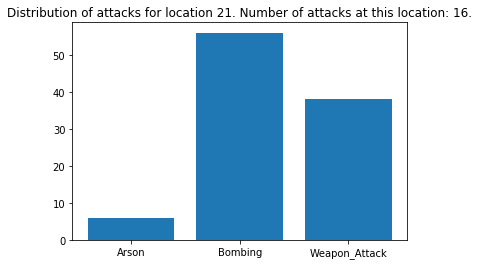

(None,
 {4.0: [{'Arson': 50.0}, {'Weapon_Attack': 50.0}, 2],
  11.0: [{'Arson': 20.0}, {'Bombing': 80.0}, 5],
  14.0: [{'Arson': 50.0}, {'Bombing': 50.0}, 2],
  15.0: [{'Arson': 33.0}, {'Bombing': 67.0}, 3],
  21.0: [{'Arson': 6.0}, {'Bombing': 56.0}, {'Weapon_Attack': 38.0}, 16],
  54.0: [{'Bombing': 94.0}, {'Weapon_Attack': 6.0}, 16],
  62.0: [{'Bombing': 100.0}, 5],
  63.0: [{'Bombing': 67.0}, {'Weapon_Attack': 33.0}, 3],
  83.0: [{'Bombing': 33.0}, {'Weapon_Attack': 67.0}, 3],
  86.0: [{'Bombing': 100.0}, 5],
  107.0: [{'Bombing': 100.0}, 5],
  116.0: [{'Bombing': 50.0}, {'Weapon_Attack': 50.0}, 2],
  127.0: [{'Bombing': 100.0}, 2],
  135.0: [{'Bombing': 33.0}, {'Weapon_Attack': 67.0}, 3],
  146.0: [{'Bombing': 50.0}, {'Weapon_Attack': 50.0}, 2],
  162.0: [{'Bombing': 67.0}, {'Weapon_Attack': 33.0}, 3],
  182.0: [{'Bombing': 100.0}, 7],
  207.0: [{'Bombing': 50.0}, {'Weapon_Attack': 50.0}, 4],
  208.0: [{'Bombing': 50.0}, {'Kidnapping': 50.0}, 2],
  215.0: [{'Bombing': 100.0}, 2],


In [11]:
plot_recap_label(21), recap_label

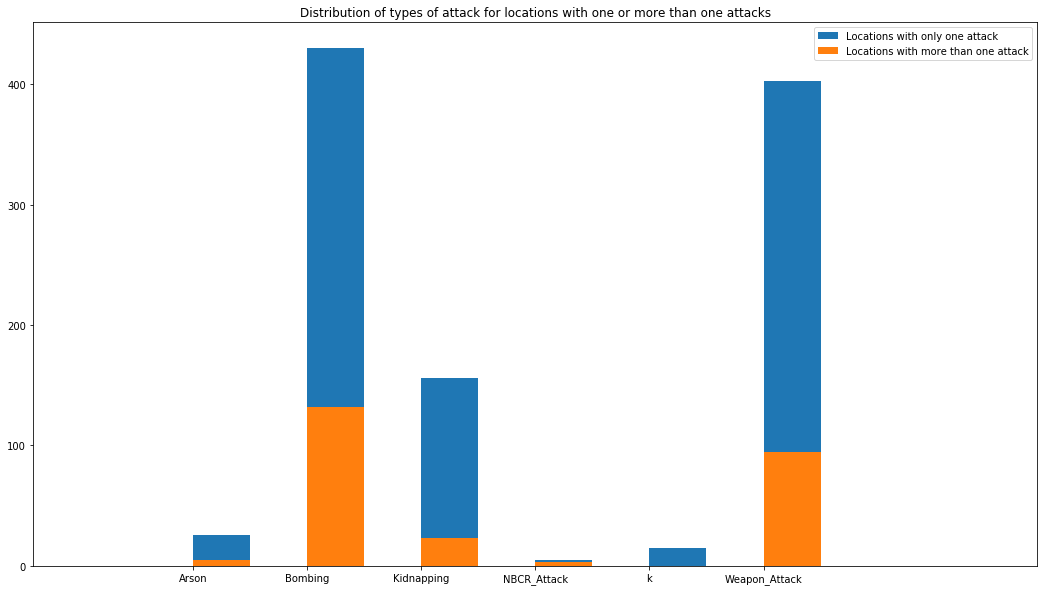

In [12]:
plt.figure(figsize=(18,10))
y_single_attack = np.take(labels,index_attack)
y_single_attack = np.reshape(y_single_attack,(y_single_attack.shape[0],1))

y_multiple_attack = np.delete(labels,index_attack)
y_multiple_attack = np.reshape(y_multiple_attack,(y_multiple_attack.shape[0],1))

plt.hist(y_multiple_attack, bins = np.linspace(-1,7,17))
plt.hist(y_single_attack, bins = np.linspace(-1,7,17))
plt.legend(('Locations with only one attack','Locations with more than one attack'))
plt.title('Distribution of types of attack for locations with one or more than one attacks')
plt.show()

##### **Remarks**

We see that the distribution of types of attack is almost the same between the locations with more than one attack (in orange) and the locations with only one attack (blue)

In [58]:
## Any ressemblance in terms of features for attacks with same label?
# Creation of a dictionnary with the 6 different types of attack and the indices of the nodes with this type of attack

unique_ele, unique_indices, unique_counts = np.unique(labels, return_index = True, return_counts = True)
dict_labels = {}
for i in range(0,len(unique_ele)):
    dict_labels[unique_ele[i]] = {'numbers':unique_counts[i], 'indices':np.where(labels == unique_ele[i])[0]}
        

In [14]:
e, U = np.linalg.eigh(adjacency_weights)

In [97]:
mydic = {'Arson':np.array([[1,0,0,0,0,0]]), 'Bombing':np.array([[0,1,0,0,0,0]]), 'Kidnapping':np.array([[0,0,1,0,0,0]]), 'NBCR_Attack':np.array([[0,0,0,1,0,0]]), 'Weapon_Attack':np.array([[0,0,0,0,1,0]]), 'k':np.array([[0,0,0,0,0,1]])}

mydic[labels[3][0]]
gt = mydic[labels[0][0]]
for i in range (1,len(labels)):
    gt = np.vstack((gt,mydic[labels[i][0]]))

x0 = np.zeros((106,6))

In [169]:
def costLS (x,f,gt):
    f_=f.astype(float)
    gt_=gt.astype(float)
    cost=0
    length=f_.shape[0]
    x=x.reshape((106,6))
    #print(f_.shape)
    #print(x.shape)
    #print(gt_.shape)
    
    if f_.shape[0] != gt_.shape[0]:
        exit('Dim missmatch')
    for i in range(0,length):
        #print(np.linalg.norm(np.dot(f_[i,:],x)-gt_[i,:]))
        tmp=np.linalg.norm(np.dot(f_[i,:],x)-gt_[i,:])
        cost += tmp
    
    #print(cost)
    return cost

In [243]:
def gradLS(x,f,gt):
    f_=f.astype(float)
    gt_=gt.astype(float)
    grad = np.zeros((106,6))
    
    for i in range (0,1293):
        er=np.dot(f_[i,:],x)-gt_[i,:]
        dif=f_[i,:]
        dif = dif.reshape((106,1))
        grad += 2*dif*er
    grad = grad/1293
    return grad

In [254]:
def grad_descent (x0,f,gt,niter,gam,verbose):
    
    tmp=x0
    for i in range (0,niter):
        x_p=tmp-gam*gradLS(tmp,f,gt)
        tmp=x_p
        if i%verbose==0:
            print(costLS(x_p,f,gt))
    return x_p


In [255]:
x=grad_descent(x0,features,gt,10000,0.1,100)

1044.9662948267294
459.9117565404581
447.0500640439691
443.1486411785943
441.1312818195289
439.7623326135414
438.7107340380427
437.8509334508354
437.10935065424775
436.4558215779469
435.8738654343616
435.3522604094785
434.8825427312309
434.4579926366093
434.07311534144606
433.72333321130964
433.4047845299565
433.1141811388282
432.8487021903356
432.60591321077516
432.3837049899436
432.1802482222165
431.99395805924297
431.82345812182587
431.66752913667574
431.52503401620396
431.3948403569856
431.2757893537613
431.16673281388626
431.0665983326162
430.9744321796366
430.88940757525955
430.81081225584916
430.7380299579637
430.6705231110736
430.6078188232521
430.5494980599012
430.4951873321968
430.44455221754544
430.39729218699637
430.3531363669554
430.311839979795
430.2731812905121
430.23695894308423
430.20298960868064
430.1711058944511
430.1411544802229
430.112994463335
430.0864959004312
430.06153853961735
430.0380107376701
430.01580855508513
429.99483501769237
429.97499952833823
429.956217

In [355]:
tot=0
for i in range(0,1293):
    if np.argmax(gt[i,:])==np.argmax(np.dot(features[i,:],x)):
        tot +=1
perf=100/1293*tot
print(perf)

88.78576952822893


In [356]:
print(np.dot(features[200,:],x))
gt[200,:]

[-0.0315568   0.86844299 -0.0433282  -0.01592944  0.18155131  0.04045693]


array([0, 1, 0, 0, 0, 0])

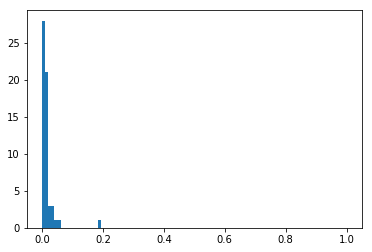

In [284]:
plt.hist(x[:,5], bins = np.linspace(0,1,100))   
plt.show()

In [556]:
np.save('projection_matrix',x)
np.save('gt',gt)

In [92]:
def spectral_clustering (feature,kernel,thf,gt,weighted,Ltype,k):
    
    #creating adjacency
    distances = pdist(feature, metric=kernel)
    kernel_width = distances.std()
    weights = np.exp(-distances**2 / kernel_width**2)
    #plt.hist(tmp, bins = np.linspace(0,1,100))   
    #plt.show()
    if weighted==1:
        
        th=weights.mean()*thf
        #print(th)
        weights[weights<=th]=0
        weights[weights>th]=1
    adjacency = squareform(weights) # features identical: weigths = 0; features different: weights >= 1
    
    #laplacian
    degree=adjacency.sum(axis=0)
    adjacency = sparse.csr_matrix(adjacency)
    
    D = sparse.diags(degree)
    D_rw=sparse.diags(1/degree)
    D_n = sparse.diags(1/np.sqrt(degree))
    L = D - adjacency
    L_rw = D_rw.dot(L)
    L_n = D_n.dot(L.dot(D_n))
    
    if Ltype=='std':
        Lap=L
    if Ltype=='rw':
        Lap=L_rw
    if Ltype=='norm':
        Lap=L_n
    
    #spectral decomposition
    e, U = np.linalg.eigh(Lap.A)
    
    #plot eigenmaps
    #plt.figure(figsize=(18,12))
    fig = plt.figure(figsize=(12,12))
    ax = Axes3D(fig)
    ax.scatter(U[:,1],U[:,2],U[:,3],c=np.argmax(gt,axis=1),cmap='rainbow')
    #plt.show()
    
    
    #clustering
    #sc 2
    sc= SpectralClustering(k, affinity='precomputed')
    
    fig3 = plt.figure(figsize=(12,12))
    ax3 = Axes3D(fig3)
    ax3.scatter(U[:,1],U[:,2],U[:,3],c=sc.fit_predict(adjacency),cmap='rainbow')
    
    return ax, ax3

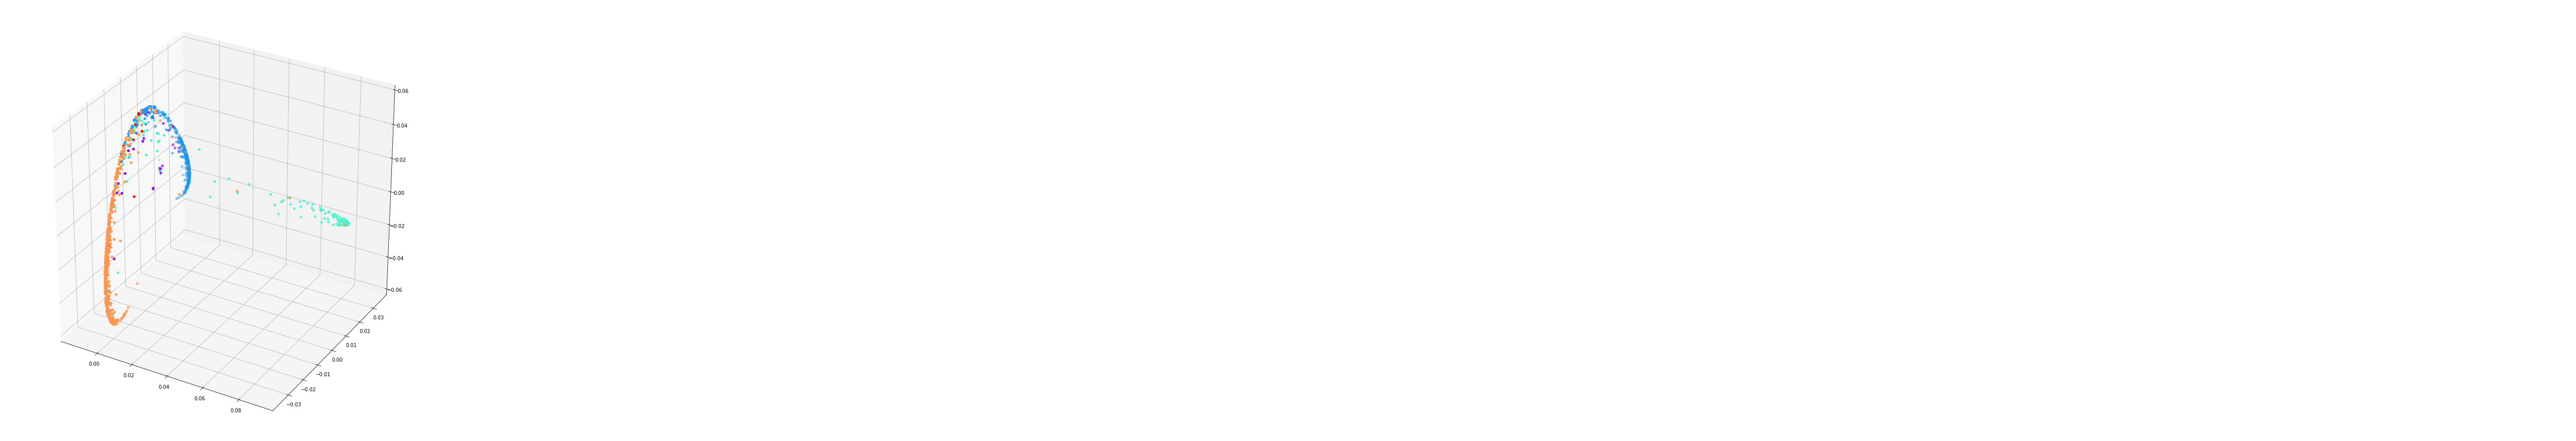

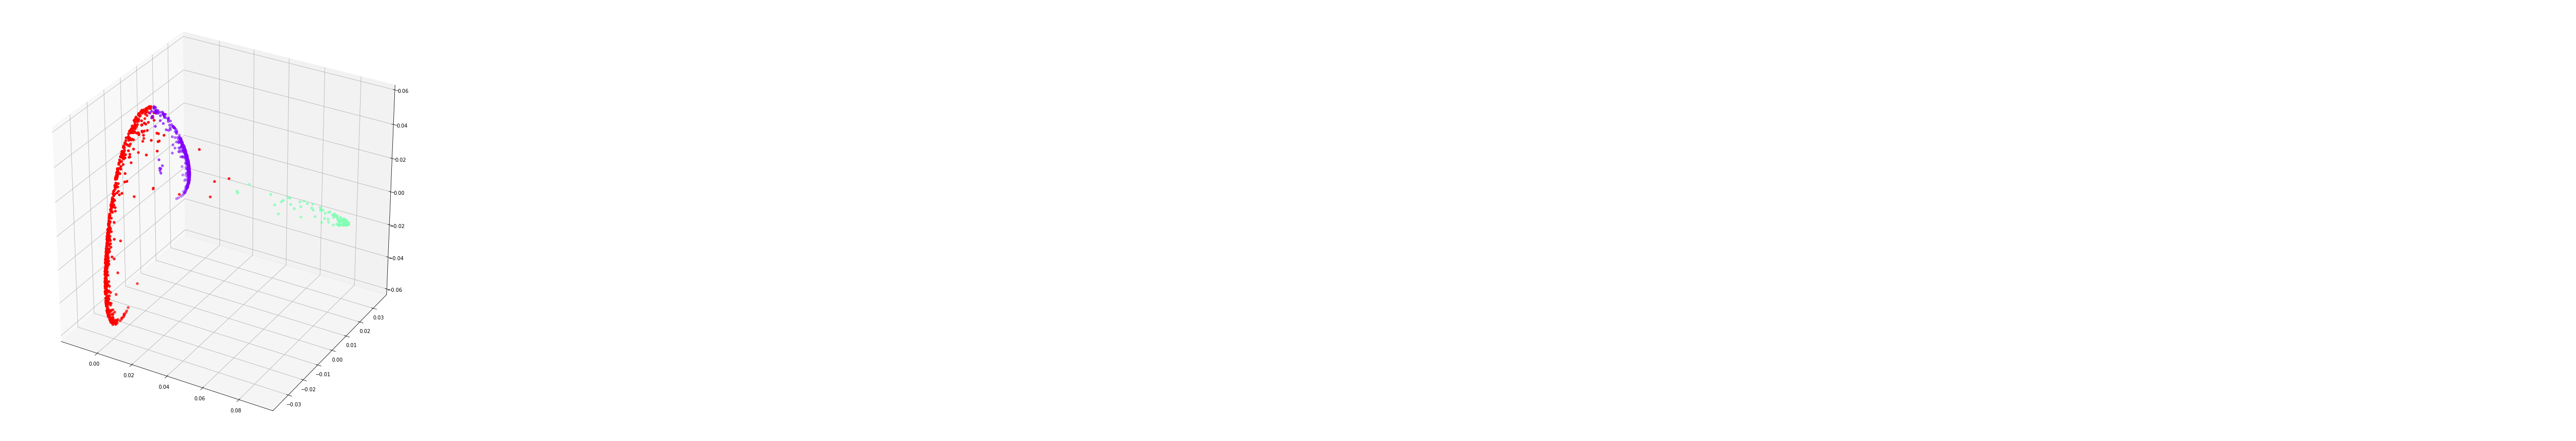

In [97]:
[a,b]=spectral_clustering(np.dot(features,x),'euclidean',1,gt,0,'norm',3)

#plt.draw()